Code for PRIMES 2023 Project - Visualizing Distributed Traces in Aggregate

In [4]:
# Imports
import json
import time
import random
import collections

In [5]:
# Connect this notebook to Google Drive where trace files should be uploaded
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Global variables for user editing

"""
Choose file that contains traces.

Ex options:
trace3.json for set of 24 traces with services like A1, B1, C1, ...
trace4.json for set of 2 traces with meaningful service names
ts-admin-user-service.json for train ticket sample traces
"""
file_name = "trace4.json"

definition_type = "services"
# definition_type = "topology"

threshold = 0.8

In [7]:
# Standard globabl variables

file_path = "drive/MyDrive/Primes2023/TraceData/"
with open(file_path + file_name) as f:
    data = json.load(f)
    raw_trace_data = data["data"]

# Number of Groups
n = len(raw_trace_data)
print("Number of Groups: " + str(n))

traces = {}
trace_ids = {}
spanid2servicename = {}

Number of Groups: 2


In [8]:
# Functions to retrieve and analyze traces

def getTrace(index):
    trace_id = raw_trace_data[index]["traceID"]
    services = []
    edges = []
    processes = raw_trace_data[index]["processes"]
    for process in processes:
        services.append(processes[process]["serviceName"])
    spans = raw_trace_data[index]["spans"]
    for span in spans:
        span_name = span["spanID"]
        process_id = span["processID"]
        service_name = processes[process_id]["serviceName"]
        spanid2servicename[span_name] = service_name
        if "references" in span and len(span["references"]) != 0:
            if span["references"][0]["refType"] == "CHILD_OF":
                edges.append([span["references"][0]["spanID"], span_name])
            elif span["references"][0]["refType"] == "PARENT_OF":
                edges.append([span_name, span["references"][0]["spanID"]])

    unique_services = list(set(services))
    trace_ids[index] = trace_id

    return (unique_services, edges)

def trace_definition(trace_id):
    services, edges = traces[trace_id]
    if definition_type == "services":
        return services
    elif definition_type == "topology":
        return edges

def intersection(trace_a, trace_b):
    common = [element for element in trace_a if element in trace_b]
    return common

In [9]:
# Connected Components
# Source: https://www.geeksforgeeks.org/connected-components-in-an-undirected-graph/
class ConnectedComponents:
  # function to merge two components
  def merge(self, parent, x):
    if parent[x] == x:
      return x
    return self.merge(parent, parent[x])

  # function to find connected components
  def connectedComponents(self, n, edges):
    # list to store parents of each node
    parent = [i for i in range(n)]

    # loop to set parent of each node
    for x in edges:
      parent[self.merge(parent, x[0])] = self.merge(parent, x[1])

    # count to store number of connected components
    ans = 0
    # loop to count number of connected components
    for i in range(n):
      if parent[i] == i:
        ans += 1

    # loop to merge all components
    for i in range(n):
      parent[i] = self.merge(parent, parent[i])

    # map to store parent and its connected components
    m = collections.defaultdict(list)
    for i in range(n):
      m[parent[i]].append(i)

    return m

In [10]:
# Function to identify groups
def getGroups(threshold):

    edges = []

    degrees = {}
    for i in range(0, n):
        degrees[i] = 0

    for trace_a in range(0, n - 1):
        for trace_b in range(trace_a + 1, n):

            topology_a = trace_definition(trace_ids[trace_a])
            topology_b = trace_definition(trace_ids[trace_b])

            intersection_size = len(intersection(topology_a, topology_b))

            union_size = len(topology_a) + len(topology_b) - intersection_size

            jaccardian_similarity = intersection_size/union_size

            if jaccardian_similarity >= threshold:
                edges.append([trace_a, trace_b])
                edges.append([trace_b, trace_a])
                if trace_a in degrees:
                    degrees[trace_a] += 1
                if trace_b in degrees:
                    degrees[trace_b] += 1

    cc = ConnectedComponents().connectedComponents(n, edges)

    return (cc, degrees, len(cc))

# Grouping Similar Traces

In [11]:
start = time.time()

for i in range(0, n):
    traces[trace_ids[i]] = getTrace(i)

cc, degrees, num_groups = getGroups(threshold)

# print(cc)

group_num = 0

components = ""

for it in cc.items():
    l = it[1]
    if group_num == 0:
        components += ("[[" + ", ".join([trace_ids[x] for x in l]) + "], ")
    elif group_num == num_groups - 1:
        components += ("[" + ", ".join([trace_ids[x] for x in l]) + "]]")
    else:
        components += ("[" + ", ".join([trace_ids[x] for x in l]) + "], ")
    group_num += 1

print(components)

group_num = 0

for it in cc.items():
    max_degree = 0
    max_degree_trace = it[0]
    l = it[1]
    degrees_cc = {}
    for x in l:
        y = int(x)
        degrees_cc[y + 1] = degrees[y]
        if degrees[y] > max_degree:
            max_degree_trace = y
        elif degrees[y] == max_degree:
            options = [max_degree_trace, y]
            max_degree_trace = random.choice(options)
            # max_degree_trace = y
        max_degree = degrees[max_degree_trace]

    print("Representative Trace for component " + str(group_num + 1) + ": " + trace_ids[max_degree_trace])

    group_num += 1

end = time.time()

# print("Time Taken: " + str(end - start) + " seconds")


[[2739abv293bn23456782], [268927abnc124]]
Representative Trace for component 1: 2739abv293bn23456782
Representative Trace for component 2: 268927abnc124


In [12]:
spanid2servicename

{'a2312512415': 'Front End',
 'b69273402735': 'Feed',
 'c12563543523434': 'Friends',
 'd68392049538467': 'Post',
 'e098765367859948736': 'Friends Database',
 'f5678948736278457': 'Front End',
 'g4577652345352': 'Friends',
 'h09876567283525': 'Friends Database'}

In [13]:
# list of traces without the trace ids
traces_without_ids = list(traces.values())
traces_without_ids

[(['Feed', 'Friends', 'Post', 'Front End', 'Friends Database'],
  [['a2312512415', 'b69273402735'],
   ['b69273402735', 'c12563543523434'],
   ['b69273402735', 'd68392049538467'],
   ['c12563543523434', 'e098765367859948736']]),
 (['Friends Database', 'Friends', 'Front End'],
  [['f5678948736278457', 'g4577652345352'],
   ['g4577652345352', 'h09876567283525']])]

# Visualizing Groups

In [14]:
#Using graph tool in collab
#Source: https://colab.research.google.com/github/count0/colab-gt/blob/master/colab-gt.ipynb#scrollTo=6km1lWMF2kAm

!echo "deb http://downloads.skewed.de/apt jammy main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo

Executing: /tmp/apt-key-gpghome.TvCkBf6Mik/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: public key "Tiago de Paula Peixoto <tiago@skewed.de>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 http://downloads.skewed.de/apt jammy InRelease [7,536 B]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,046 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,326 kB]
Hit:10 https://ppa.launchpadcontent

In [15]:
# Colab uses a Python install that deviates from the system's! Bad collab! We need some workarounds.
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages will be REMOVED:
  python3-cairo*
0 upgraded, 0 newly installed, 1 to remove and 27 not upgraded.
After this operation, 310 kB disk space will be freed.
(Reading database ... 130030 files and directories currently installed.)
Removing python3-cairo:amd64 (1.20.1-3build1) ...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pkg-config is already the newest version (0.29.2-1ubuntu3).
python3-dev is already the newest version (3.10.6-1~22.04).
python3-dev set to manually installed.
The following additional packages will be installed:
  libblkid-dev libcairo-script-interpreter2 libffi-dev libglib2.0-dev libglib2.0-dev-bin libice-dev
  liblzo2-2 libmount-dev libpixman-1-dev libselinux1-dev libsepol-dev libsm-dev libxcb-render0-dev
  libxcb-shm0-dev
Suggested packages:
  libcairo2-doc libgirepository1.0-dev libglib2.0-doc libg

In [16]:
%pip install matplotlib-venn
import graph_tool.all as gt
import matplotlib_venn as venn
from matplotlib_venn import venn2
import pylab as plt

# Converting output

In [17]:
#let len(set) = s
def rep_to_vis(R_set):
    #adding s+3 lists
    V_list = []
    for i in range(3):
        V_list.append([])

    #adding node names to a set bc it's faster
    Nodes = set()
    #all service names
    for index in range(len(R_set)):
        for index2 in range(len(R_set[index][0])):
            Nodes.update((R_set[index][0]))
    #converting set back to list
    node_list = list(Nodes.copy())

    V_list[0] = node_list


    #creating counts of each node starting with 0
    call_list = []
    for index in range(len(node_list)):
        call_list.append(0)
    #adding total calls of each node
    for index in range(len(R_set)):
        for node in node_list:
            if node in R_set[index][0]:
                call_list[node_list.index(node)] += 1


    V_list[1] = call_list


    #adding total # of traces
    V_list[2].append(len(R_set))


    #adding empty cells to each node
    for i in range(len(node_list)):
        V_list.append([])
        for j in range(len(node_list)):
            V_list[i+3].append(0)
    #adding calls to each node
    for index in range(len(R_set)):
        for index2 in range(len(R_set[index][1])):
            for node in node_list:
              # change this part
                if spanid2servicename[R_set[index][1][index2][0]] == node:
                    V_list[3+node_list.index(node)][node_list.index(spanid2servicename[R_set[index][1][index2][1]])] += 1



    return(V_list)

In [18]:
print(traces_without_ids)

print(rep_to_vis(traces_without_ids))

{'a1': 'Front End',
 'b1': 'Friends',
 'c1': 'Friends Database',
 'd1': 'Post',
 'e1': 'Friends Database'}



[(['Feed', 'Friends', 'Post', 'Front End', 'Friends Database'], [['a2312512415', 'b69273402735'], ['b69273402735', 'c12563543523434'], ['b69273402735', 'd68392049538467'], ['c12563543523434', 'e098765367859948736']]), (['Friends Database', 'Friends', 'Front End'], [['f5678948736278457', 'g4577652345352'], ['g4577652345352', 'h09876567283525']])]
[['Feed', 'Friends Database', 'Friends', 'Post', 'Front End'], [1, 2, 2, 1, 2], [2], [0, 0, 1, 1, 0], [0, 0, 0, 0, 0], [0, 2, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 1, 0, 0]]


{'a1': 'Front End',
 'b1': 'Friends',
 'c1': 'Friends Database',
 'd1': 'Post',
 'e1': 'Friends Database'}

Single Group View

In [19]:
#single group view
import matplotlib.pyplot as plt

def single_group_view(group1):
    g = gt.Graph()
    #adding number of vertices from number of nodes
    vlist = g.add_vertex(len(group1[0]))


    vertex_t = g.new_vp('string') #vertex text

    vertex_s = g.new_vp("double") #vertex size

    vertex_c = g.new_vp("string") #vertex_color

    vertex_t_s = g.new_vp("double") #vertex text size


    totalNodeNum = 0
    for index in range(len(group1[0])): #getting average size of a node
        totalNodeNum += group1[1][index]
    avg_size = 120*len(group1[0])/totalNodeNum #50 is temp scalar


    for index in range(len(group1[0])):
        vertex_t[index] = group1[0][index] #vertex text
        vertex_s[index] = avg_size*group1[1][index] #vertex size
        vertex_t_s[index] = vertex_s[index]/len(vertex_t[index]) #vertex text size
        if group1[1][index] == group1[2][0]: #vertex_color
            vertex_c[index] = '#fdda0d'
        else:
            vertex_c[index] = '#d3d3d3'
#single group view of A
    gt.graph_draw(g, vertex_text = vertex_t, vertex_size = vertex_s, vertex_fill_color = vertex_c, vertex_font_size=vertex_t_s)


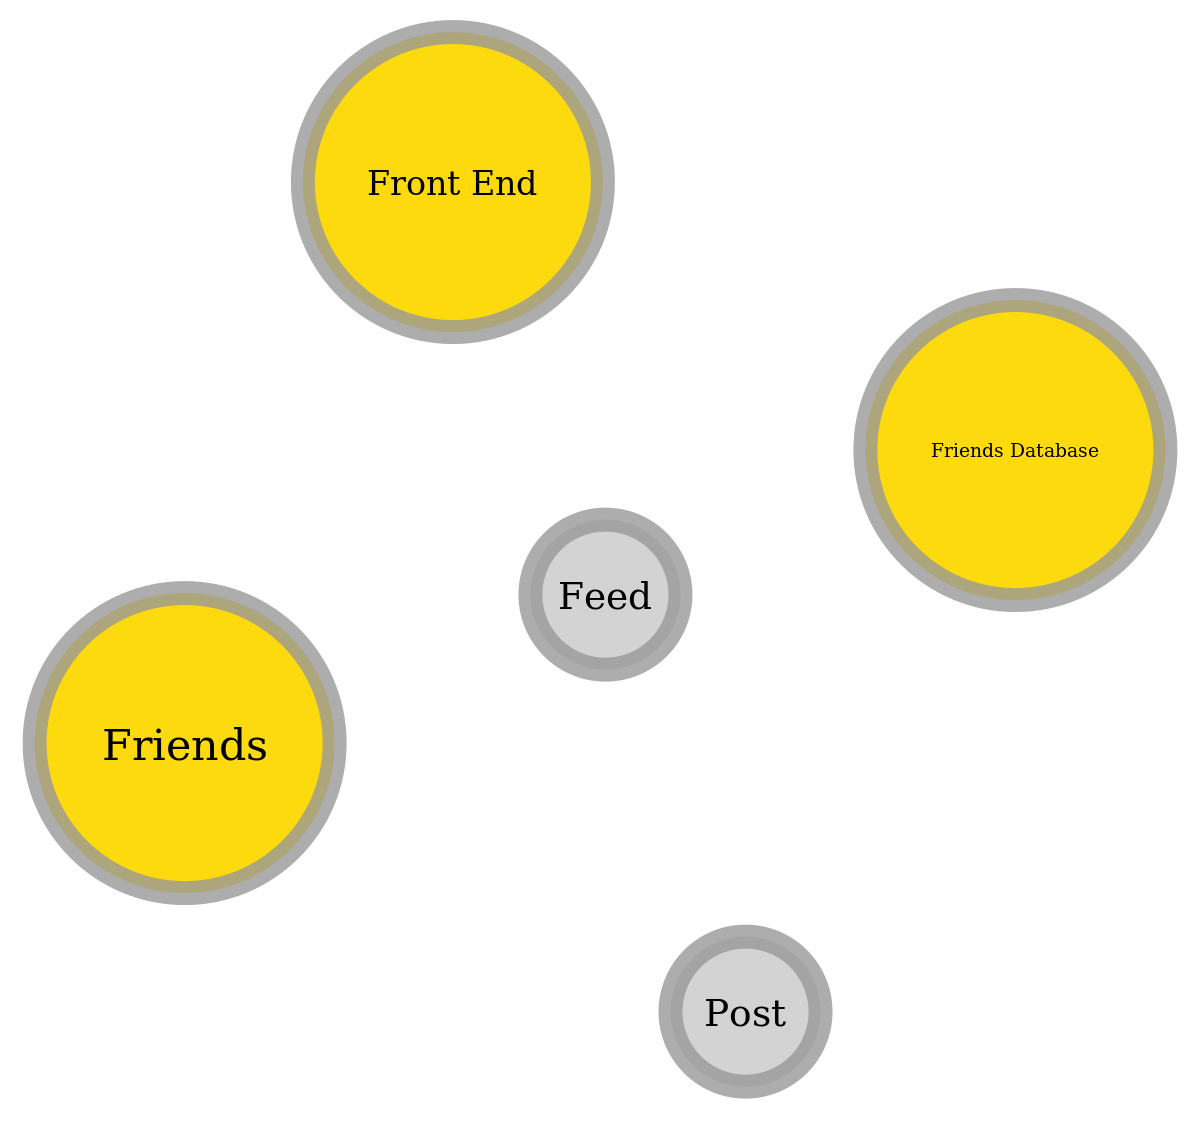

In [20]:

single_group_view(rep_to_vis(traces_without_ids))


Node view

In [21]:
#edges view
def node_view(A, group1):


    g = gt.Graph()
    #adding number of vertices from number of nodes
    vlist = g.add_vertex(len(group1[0]))


    vertex_t = g.new_vp('string') #vertex text

    vertex_s = g.new_vp("double") #vertex size

    vertex_c = g.new_vp("string") #vertex_color

    edge_s = g.new_ep("double") #edge size

    vertex_t_s = g.new_vp("double") #vertex text size



    totalNodeNum = 0
    for index in range(len(group1[0])): #getting average size of a node: 500 is a temporary max
        totalNodeNum += group1[1][index]
    avg_size = 80*len(group1[0])/totalNodeNum


    A_index = 0;
    for index in range(len(group1[0])):
        vertex_t[index] = group1[0][index] #vertex text
        vertex_s[index] = avg_size*group1[1][index] #vertex size
        vertex_t_s[index] = vertex_s[index]/len(vertex_t[index]) #vertex text size
        if group1[1][index] == group1[2][0]: #vertex_color
            vertex_c[index] = '#fdda0d'
        else:
            vertex_c[index] = '#d3d3d3'
        if group1[0][index] == A:
            vertex_c[index] = '#3cb043'
            A_index = index


    edge_total= 0 #finding total number of edges
    for i in group1[3+A_index]:
        edge_total = edge_total + i


    edge_num = 0
    for index in range(len(group1[3])): #making the edges
        if group1[3+A_index][index] != 0:
            e = g.add_edge(A_index,index)
            edge_s[e] = 4*len(group1[0])*group1[3+A_index][index]/edge_total #setting edge sizes - 40 is a temp variable
            edge_num += 1


    gt.graph_draw(g, vertex_text = vertex_t, vertex_size = vertex_s, vertex_fill_color = vertex_c, edge_pen_width = edge_s, vertex_font_size = vertex_t_s)

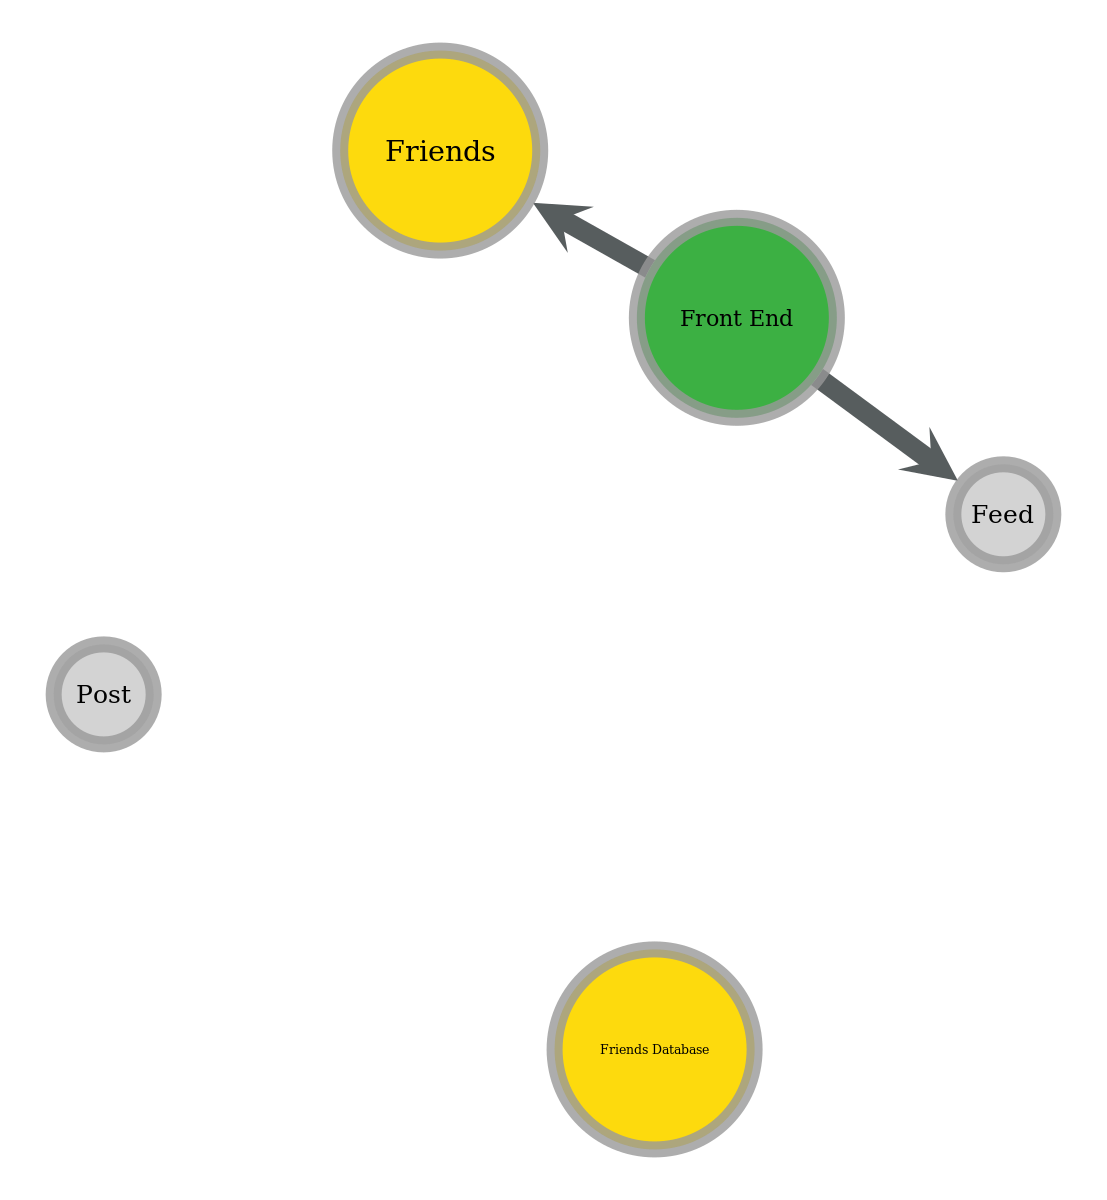

In [26]:
#node view
node_view('Front End',rep_to_vis(traces_without_ids))

Venn diagram view

In [23]:
#venn diagram view
def venn_view(A,B):
    set1 = set(A[0])
    set2 = set(B[0])

    plt.title("Sample Venn Diagram")
    venn2([set1, set2], ['Group 1', 'Group 2'])

In [24]:
venn_view(A,B)


NameError: ignored

In [ ]:
venn_view(A,C)